# Spatial mapping of cell types in the slide-seq data

### Loading packages <a class="anchor" id="Loading_packages"></a>

In [1]:
import sys
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib

data_type = 'float32'

# this line forces theano to use the GPU and should go before importing cell2location
os.environ["THEANO_FLAGS"] = 'device=cuda0,floatX=' + data_type + ',force_device=True'

sys.path.insert(1, '/nfs/team205/vk7/sanger_projects/BayraktarLab/cell2location/')
sys.path.insert(1, '/nfs/team205/vk7/sanger_projects/cell2location_dev/')

import cell2location

from matplotlib import rcParams
import seaborn as sns
import pickle

# silence scanpy that prints a lot of warnings
import warnings
warnings.filterwarnings('ignore')

%config InlineBackend.figure_format = 'retina'

Can not use cuDNN on context None: cannot compile with cuDNN. We got this error:
b'In file included from /tmp/try_flags_sohjw055.c:4:0:\n/usr/include/cudnn.h:63:10: fatal error: driver_types.h: No such file or directory\n #include "driver_types.h"\n          ^~~~~~~~~~~~~~~~\ncompilation terminated.\n'
Mapped name None to device cuda0: Tesla V100-SXM2-32GB (0000:62:00.0)


# S10b 

### SlideSeq <a class="anchor" id="read"></a> 

In [2]:
sp_data_folder = '/nfs/team205/vk7/sanger_projects/cell2location_proj/notebooks/data/stickels_et_al_2020_slide_seqV2/'
results_folder2 = '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/results/mouse_viseum_snrna/'
results_folder = '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/stickels_et_al_2020_slide_seqV2/'

In [3]:
r = {'run_name': 'CoLocationModelNB4V2_59clusters_53208locations_9069genes'}
sp_data_file = results_folder+r['run_name']+'/sp.h5ad'
adata_vis = anndata.read(sp_data_file)
total_counts = np.array(adata_vis.raw.X.sum(1))[:, 0]
adata_vis = adata_vis[total_counts < np.quantile(total_counts, 0.995)]

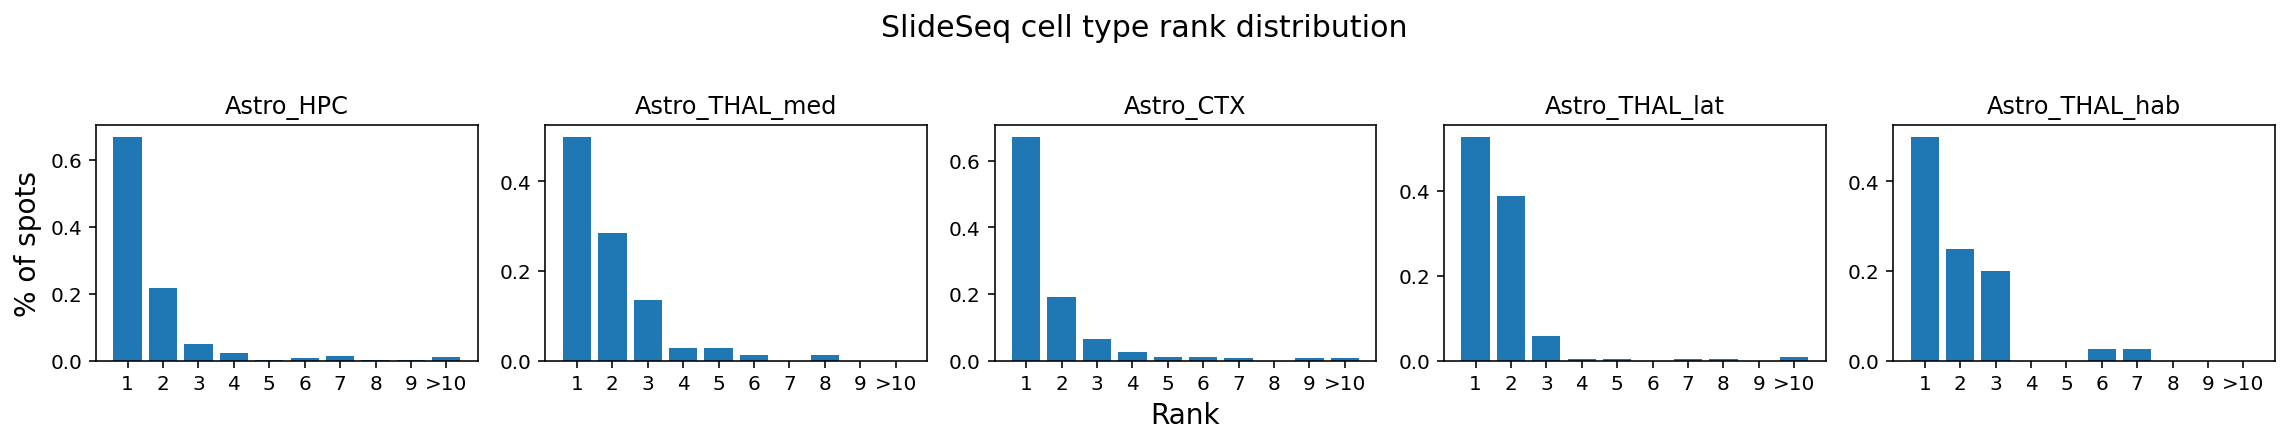

In [4]:
mean_cols = [c for c in adata_vis.obs.columns if 'mean_nUMI_factors' in c]
mean_spot = adata_vis.obs[mean_cols]



def plot_10_first(series, n=10):
    series = series.sort_index().reindex(range(0, max(n, series.index.max())), fill_value=0)
    x = series.index[:n] + 1
    x = x.values
    y = series.values
    y[n-1] += y[n-1:].sum()
    y = y[:n]
    y = y/y.sum()
    
    plt.xticks(range(1, n+1), list(range(1, n)) + [f'>{n}'])

    plt.bar(x, y)

def to_rank(a):
    return (-a).argsort(axis=1).argsort(axis=1)

rank_df = mean_spot.copy()


rank_df[:] = to_rank(rank_df.values)

# genes_of_interest = [c for c in mean_cols if 'Astro' in c]
genes_of_interest = ['mean_nUMI_factorsAstro_HPC', 'mean_nUMI_factorsAstro_THAL_med', 'mean_nUMI_factorsAstro_CTX', 
                     'mean_nUMI_factorsAstro_THAL_lat',  'mean_nUMI_factorsAstro_THAL_hab']


plt.figure(figsize=(16, 3))
    
plt.suptitle('SlideSeq cell type rank distribution', y=1.015, size=15)
    
for num, gene in enumerate(genes_of_interest):
    plt.subplot(1, 5, num + 1)
    plt.title(gene.replace('mean_nUMI_factors', ''))
    tmp = rank_df[mean_spot[gene] > 60]
    plot_10_first(tmp[gene].value_counts(sort=False).sort_index())
    if num == 2:
        plt.xlabel('Rank', size=14)
    if num == 0:
        plt.ylabel('% of spots', size=14)
plt.tight_layout()
plt.savefig('S10b_slideseq_astro.pdf', bbox_inches='tight')

Trying to set attribute `.obs` of view, copying.


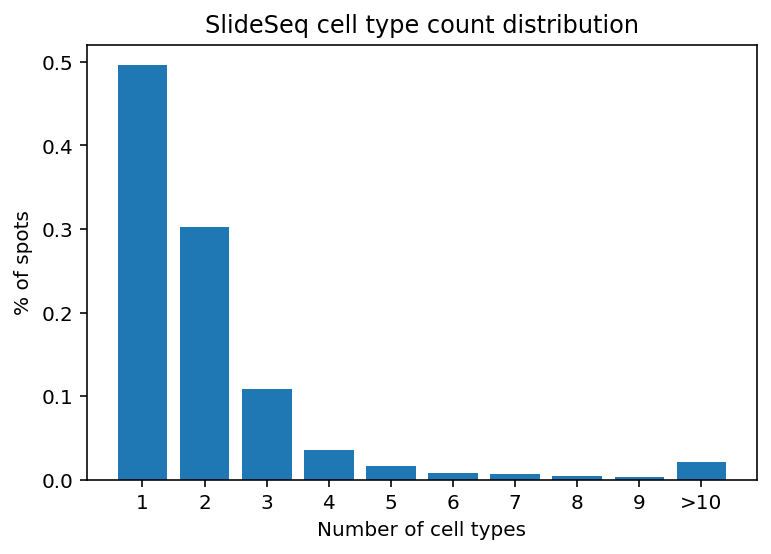

In [5]:
adata_vis.obs['cell_types_count'] = (adata_vis.obs[mean_cols].values > 40).sum(axis=1)
type_conts = adata_vis.obs['cell_types_count'].value_counts()

plot_10_first(type_conts.sort_index())

plt.title('SlideSeq cell type count distribution')
plt.xlabel('Number of cell types')
plt.ylabel('% of spots');

plt.savefig('S10b_slideseq_distribution.pdf', bbox_inches='tight')

###  Visium

In [6]:
# read a previously trained LocationModel
results_folder = '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/mouse_viseum_snrna/'
sp_results_folder = f'{results_folder}'
sc_results_folder = f'{results_folder}regression_model/'

run_name = 'CoLocationModelNB4E6V2_59clusters_14968locations_12809genes_n_comb50_mean_var5_inferred_30k'

# path for saving figures
fig_path = f'{sp_results_folder}{run_name}/plots/figures/'
sc_figpath = sc.settings.figdir
sc.settings.figdir = f'{fig_path}'

sp_data_file = f'{sp_results_folder}{run_name}/sp_with_clusters.h5ad'
adata_vis = anndata.read(sp_data_file)
slide = adata_vis[adata_vis.obs["sample"]==adata_vis.obs["sample"].unique()[0]]

In [7]:
mean_cols = [c for c in adata_vis.obs.columns if 'mean_spot_factors' in c]
mean_spot = adata_vis.obs[mean_cols]

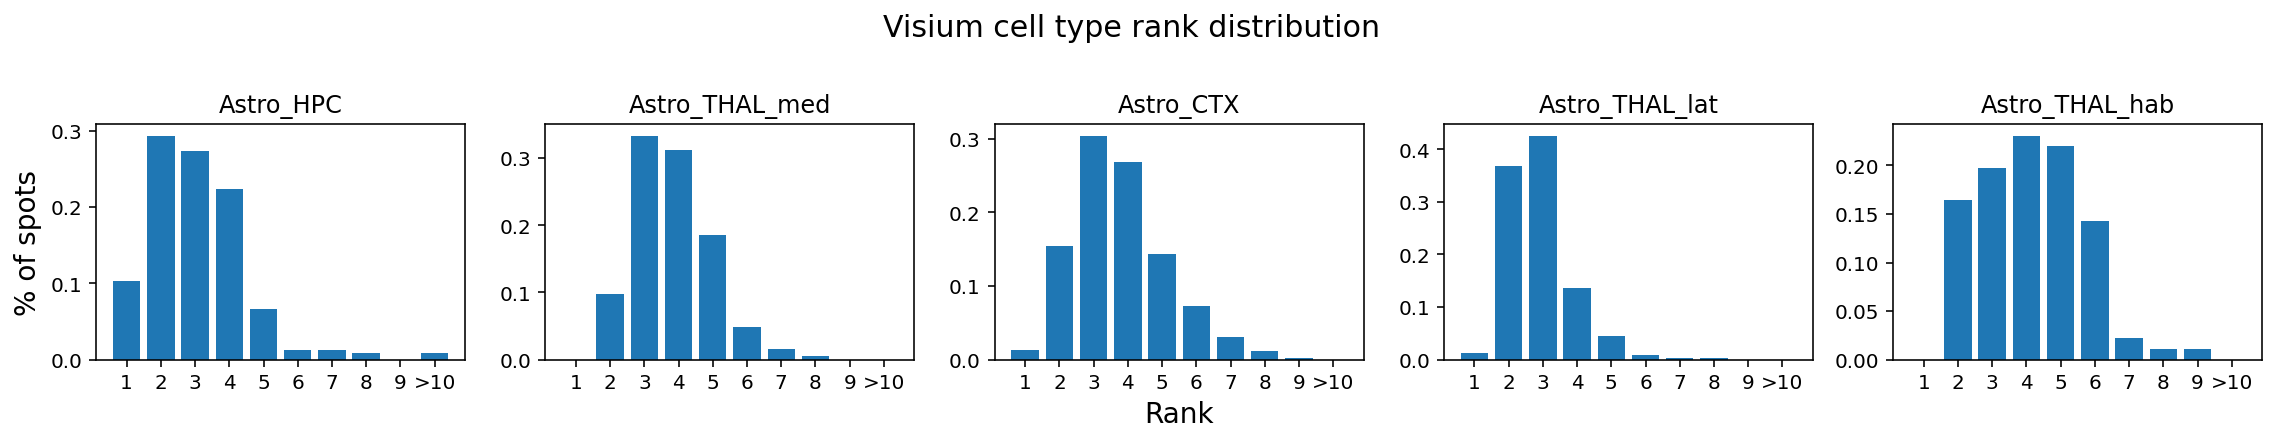

In [8]:
rank_df = mean_spot.copy()


rank_df[:] = to_rank(rank_df.values)

# genes_of_interest = [c for c in mean_cols if 'Astro' in c]
genes_of_interest = ['mean_spot_factorsAstro_HPC', 'mean_spot_factorsAstro_THAL_med', 'mean_spot_factorsAstro_CTX', 
                     'mean_spot_factorsAstro_THAL_lat',  'mean_spot_factorsAstro_THAL_hab']


plt.figure(figsize=(16, 3))
    
plt.suptitle('Visium cell type rank distribution', y=1.013, size=15)
    
for num, gene in enumerate(genes_of_interest):
    plt.subplot(1, 5, num + 1)
    plt.title(gene.replace('mean_spot_factors', ''))
    tmp = rank_df[mean_spot[gene] > 0.5]
    plot_10_first(tmp[gene].value_counts(sort=False).sort_index())
    if num == 2:
        plt.xlabel('Rank', size=14)
    if num == 0:
        plt.ylabel('% of spots', size=14)
plt.tight_layout()
plt.savefig('S10b_visium_astro.pdf', bbox_inches='tight')

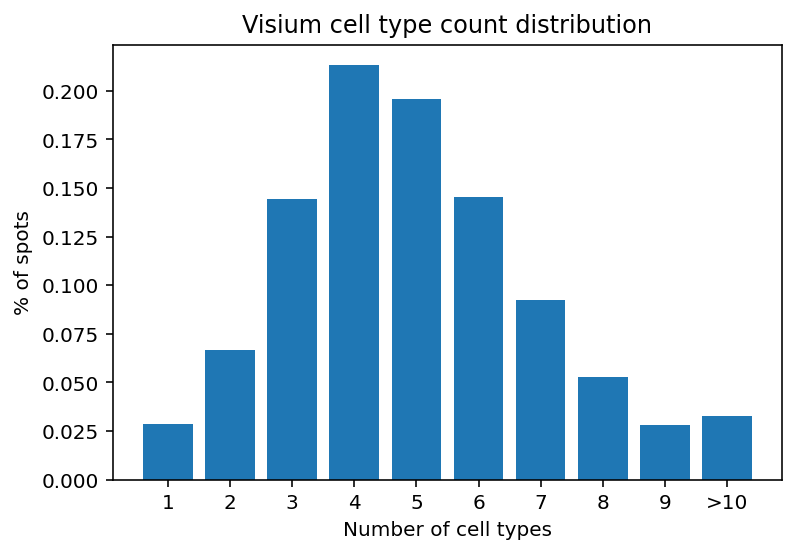

In [9]:
mean_cols = [c for c in adata_vis.obs.columns if 'mean_spot_factors' in c]
mean_spot = adata_vis.obs[mean_cols]

adata_vis.obs['cell_types_count'] = (adata_vis.obs[mean_cols].values > 0.4).sum(axis=1)
type_conts = adata_vis.obs['cell_types_count'].value_counts()

plot_10_first(type_conts.sort_index())

plt.title('Visium cell type count distribution')
plt.xlabel('Number of cell types')
plt.ylabel('% of spots');

plt.savefig('S10b_visium_distribution.pdf', bbox_inches='tight')

###  Lymph node

In [10]:
# read cell2location model results
results_folder = '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/lymph_nodes_analysis/'
sc_data_folder = '/nfs/team205/vk7/sanger_projects/cell2location_proj/notebooks/data/b_t_cells_tonsils_hk/'

run_name = 'CoLocationModelNB4V2_34clusters_4039locations_10241genes_input_inferred_V4_batch1024_l2_0001_n_comb50_5_cps5_fpc3_alpha001'

# path for saving figures
fig_path = results_folder + ''+run_name+'/plots/figures/'
sc_figpath = sc.settings.figdir
sc.settings.figdir = f'{fig_path}'


sp_data_file = results_folder + ''+run_name+'/sp_with_clusters.h5ad'
adata_vis = anndata.read(sp_data_file)
adata_vis.obs['sample'] = list(adata_vis.uns['spatial'].keys())[0]

slide = adata_vis[adata_vis.obs["sample"]==adata_vis.obs["sample"].unique()[0]]

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


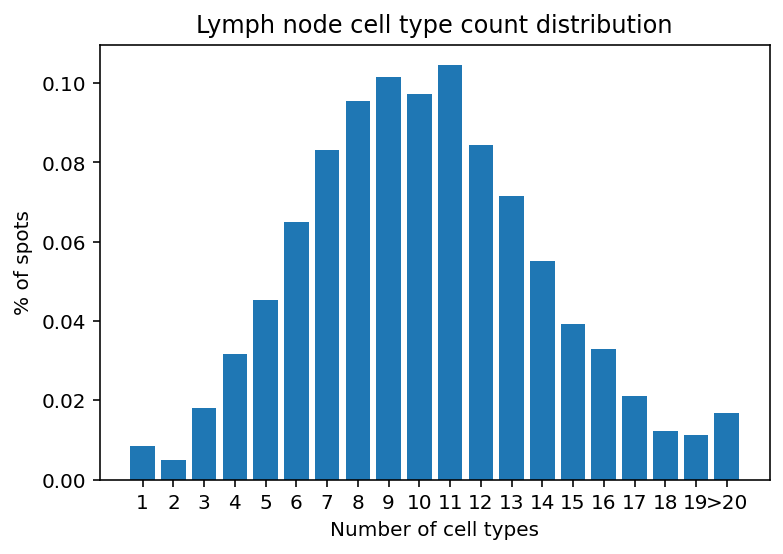

In [11]:
mean_cols = [c for c in adata_vis.obs.columns if 'mean_spot_factors' in c]
mean_spot = adata_vis.obs[mean_cols]

adata_vis.obs['cell_types_count'] = (mean_spot > 0.8).sum(axis=1)
type_conts = adata_vis.obs['cell_types_count'].value_counts()

plot_10_first(type_conts.sort_index(), n=20)

plt.title('Lymph node cell type count distribution')
plt.xlabel('Number of cell types')
plt.ylabel('% of spots');

plt.savefig('S10b_lymph_node_distribution.pdf', bbox_inches='tight')

# S10a 

In [12]:
sp_data_folder = '/nfs/team205/vk7/sanger_projects/cell2location_proj/notebooks/data/stickels_et_al_2020_slide_seqV2/'
results_folder2 = '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/results/mouse_viseum_snrna/'
results_folder = '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/stickels_et_al_2020_slide_seqV2/'

In [13]:
r = {'run_name': 'CoLocationModelNB4V2_59clusters_53208locations_9069genes'}
sp_data_file = results_folder+r['run_name']+'/sp.h5ad'
adata_vis = anndata.read(sp_data_file)
total_counts = np.array(adata_vis.raw.X.sum(1))[:, 0]
adata_vis = adata_vis[total_counts < np.quantile(total_counts, 0.995)]

In [14]:
sel_clust = ['Ext_Hpc_CA1', 'Ext_Hpc_CA2', 'Ext_Hpc_CA3', 'Ext_Hpc_DG1',
             'Inh_6', 'Ext_L23', 'Ext_L25', 'Ext_L5_2', 'Ext_L56', 'Ext_L6B']

sel_clust_lab = ['Hpc_CA1', 'Hpc_CA2', 'Hpc_CA3', 'Hpc_DG1', 'Inh_6',
             'Ext_L23', 'Ext_L25', 'Ext_L5_2', 'Ext_L56', 'Ext_L6B']

sel_clust_col = ['q05_spot_factors' + str(i) for i in sel_clust]

Trying to set attribute `.uns` of view, copying.


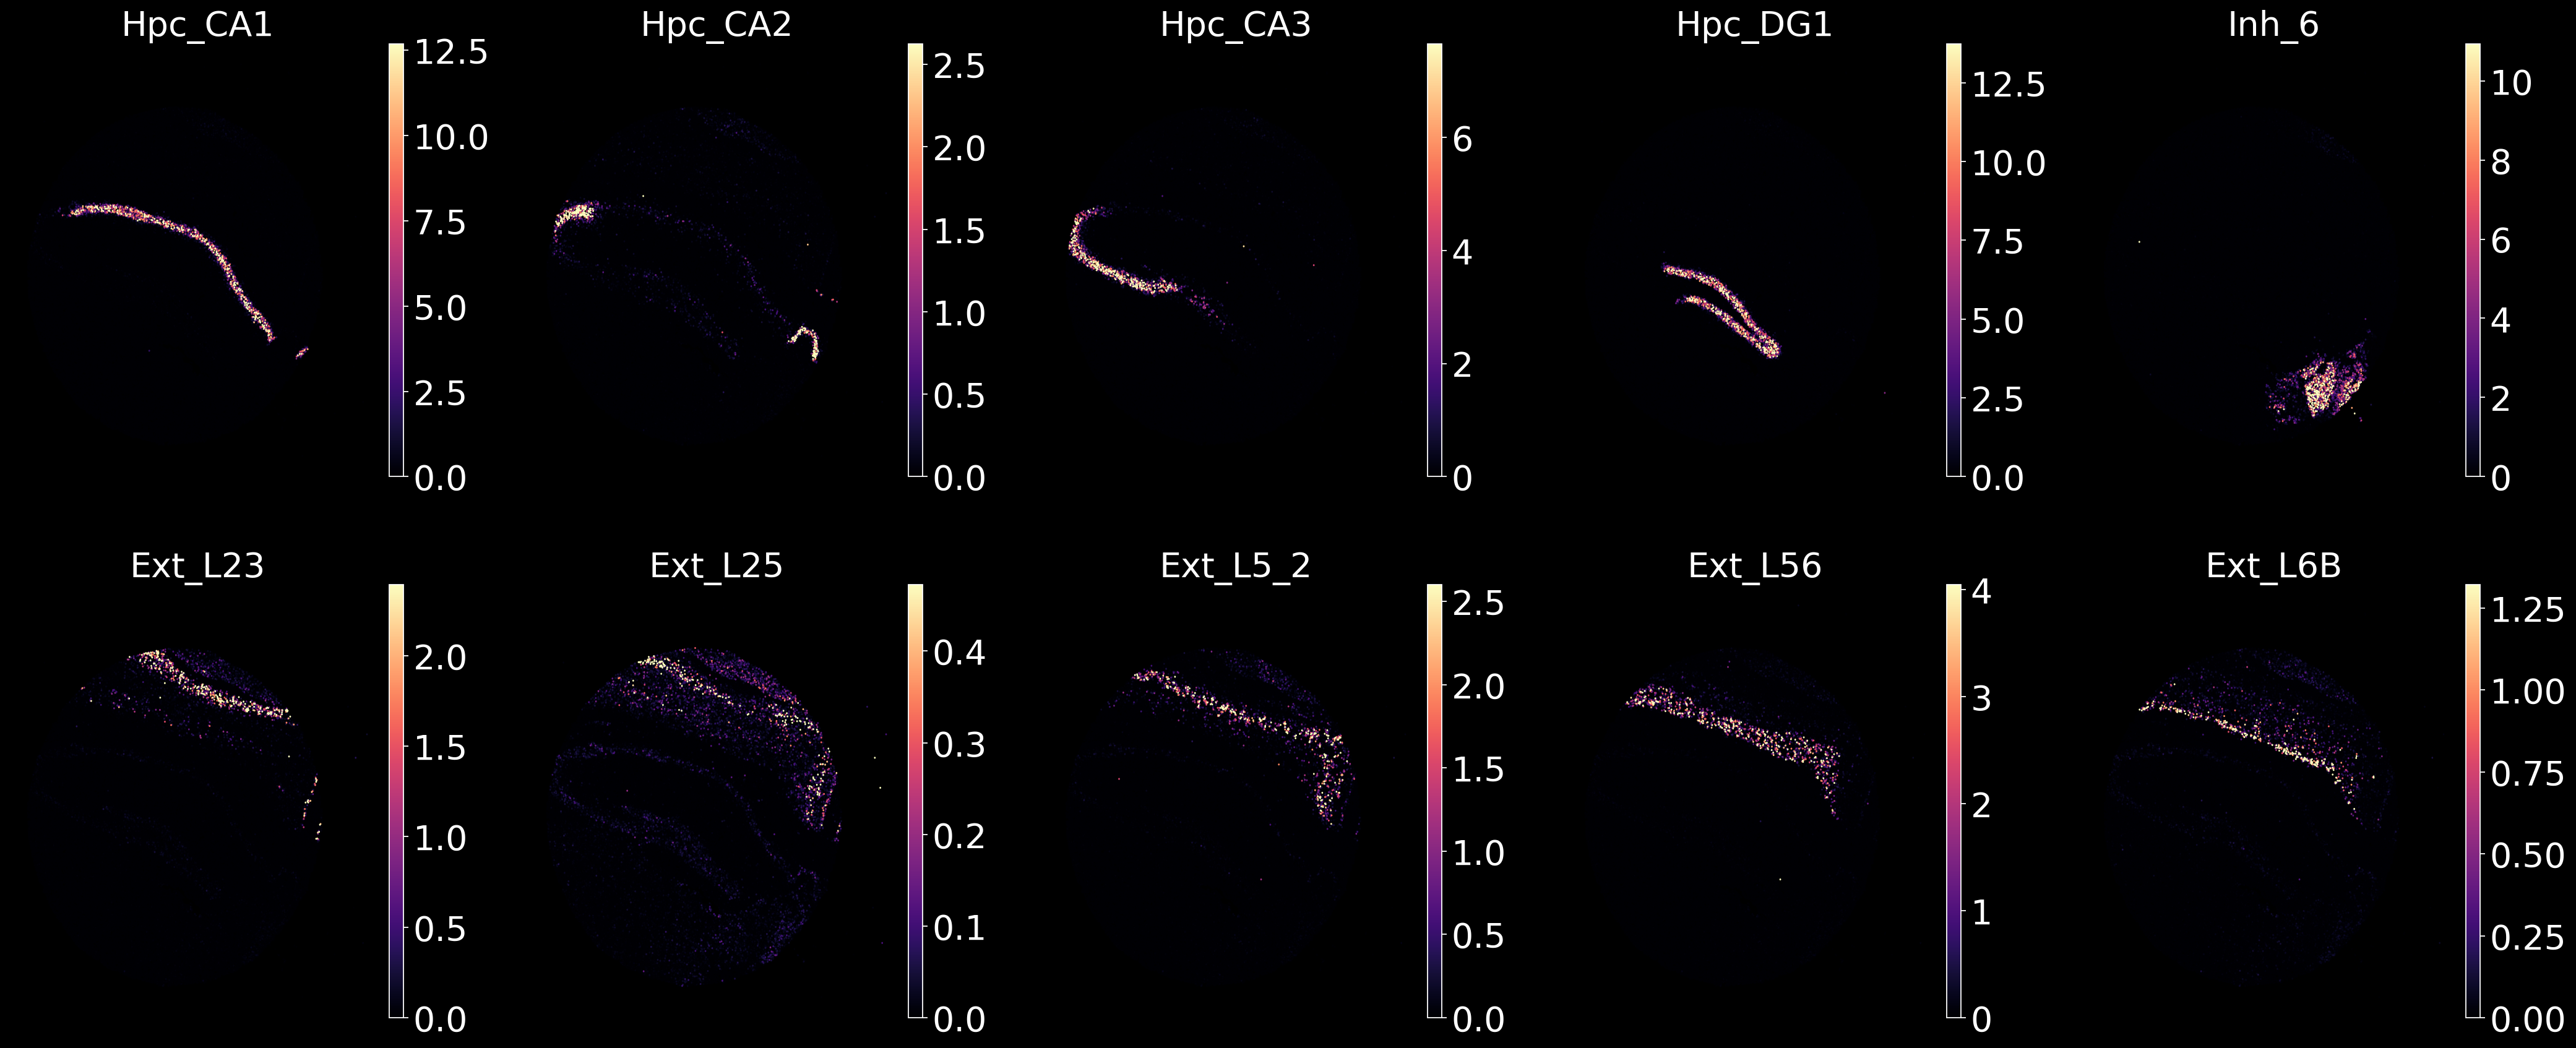

<Figure size 400x480 with 0 Axes>

In [15]:
sc_figpath ='.'
sc.settings.figdir = f'{sc_figpath}'
sc.settings.set_figure_params(vector_friendly = True, format = 'pdf', fontsize=25)

adata_vis.uns['spatial'] = {k: None for k in adata_vis.obs['filename'].unique()}

with plt.style.context('dark_background'):
    with matplotlib.rc_context({'axes.facecolor':  'black', 'figure.figsize': [5, 6], 'font.size': 45}):
        sc.pl.spatial(adata_vis, img_key = None, cmap='magma',
                      title=sel_clust_lab,
                      color=sel_clust_col, size=0.2,
                      alpha_img=0.85, vmin=0, vmax='p99.7',#vmax=5,#vmax=5000, #vmax=4,
                      ncols=5,
                      gene_symbols='SYMBOL', frameon=False, wspace=0.26, save=f'S10a.pdf')
        plt.tight_layout();
    plt.show()